# FaultTree

## Install

Use Pkg to install the packages. The packages are located in GitHub.

https://github.com/JuliaReliab/FaultTree.jl


In [ ]:
using Pkg
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/DD.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/FaultTree.jl.git"))

### Install Graphviz

In [ ]:
;sudo apt-get update -y

In [ ]:
;sudo apt-get install -y graphviz

In [ ]:
using Pkg
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/JuliaDot.jl.git"))

## Initialize

Load `FaultTree`

In [ ]:
using DD.BDD
using FaultTree
using JuliaDot

### Example 1

#### Definition of FT model

In [ ]:
@basic x, y, z
te = x & y | z

### Draw BDD

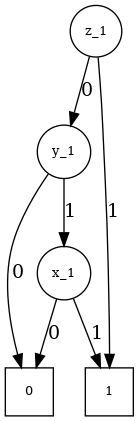

In [56]:
ft = FTree()
f = ftbdd!(ft, te)
draw(BDD.todot(f))

#### Minimal path (cut) set

In [ ]:
mcs(ft, te)

#### Eval top event (system reliability)

In [ ]:
env = @parameters begin
    x = 0.999
    y = 0.999
    z = 0.999
end

prob(ft, te, env)

In [ ]:
## Structure importance
smeas(ft, te)

## Example 2

A FT example of Figure 9.20 in R.A. Sahner, K.S. Trivedi and A. Puliafito, Performance and Reliability Analysis of Computer Systems, Kluwer Academic Publishers, 1996.

In [ ]:
## aircraft flight control system

## events
@basic IRS, PRS, CS, SA

IRS23 = ftkofn(2, [IRS for _ = 1:3]...)
PRS23 = ftkofn(2, [PRS for _ = 1:3]...)
CS34 = ftkofn(3, [CS for _ = 1:4]...)
SAS23 = ftkofn(2, [SA for _ = 1:3]...)
TOP = IRS23 | PRS23 | CS34 | SAS23

In [ ]:
## Compute
ft = FTree()

mIRS = 0.000015
mPRS = 0.000019
mSA  = 0.000037
mCS  = 0.00048

function mkenv(t; mIRS, mPRS, mSA, mCS)
    @parameters begin
        IRS = 1-exp(-mIRS*t)
        PRS = 1-exp(-mPRS*t)
        CS = 1-exp(-mCS*t)
        SA = 1-exp(-mSA*t)
    end
end

[(t, prob(ft, TOP, mkenv(t; mIRS=mIRS, mPRS=mPRS, mSA=mSA, mCS=mCS))) for t = 1000:1000:10000]

In [ ]:
## Structure importance
smeas(ft, TOP)

In [ ]:
## Birnbaum importance
[(t, bmeas(ft, TOP, mkenv(t; mIRS=mIRS, mPRS=mPRS, mSA=mSA, mCS=mCS))) for t = 1000:1000:10000]

In [ ]:
## Criticality importance
[(t, c0meas(ft, TOP, mkenv(t; mIRS=mIRS, mPRS=mPRS, mSA=mSA, mCS=mCS))) for t = 1000:1000:10000]

In [ ]:
## Criticality importance
[(t, c1meas(ft, TOP, mkenv(t; mIRS=mIRS, mPRS=mPRS, mSA=mSA, mCS=mCS))) for t = 1000:1000:10000]